In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib

import ribasim

import ribasim_lumping
from ribasim_lumping.ribasim_model_results import plot_results_basin_ribasim_model, \
    plot_results_basins_ribasim_model, get_ribasim_basin_data_from_model, read_ribasim_model_results

import pandas as pd
import geopandas as gpd
import numpy as np
import pyarrow as pa
import datetime

import warnings

warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

c:\Users\NLHARN\Documents\PROGRAMMING\ribasim_lumping_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

##### SET-UP NETWORK

In [3]:
# define network name, base dir
network_name            = "tki_zutphen_berkel"
base_dir                = Path("..\\..\\..\\ribasim_lumping_data\\")
# base_dir                = Path("..\\..\\..\\..\\..\\..\\ribasim_lumping_data\\")
# directory D-HYDRO basis calculations
dhydro_basis_dir        = Path(base_dir, network_name, "2_dhydro\\") # zelfde directory, want gebruik zelfde som
# directory D-HYDRO results calculations
dhydro_results_dir      = Path(base_dir, network_name, "2_dhydro\\") # zelfde directory, want gebruik zelfde som
# directory results
results_dir             = Path(base_dir, network_name, "3_ribasim\\")
# batch file used to calculate volume D-Hydro module per GridPoint
dhydro_volume_tool_bat_file = Path(r"c:\Program Files\Deltares\D-HYDRO Suite 2023.03 1D2D\plugins\DeltaShell.Dimr\kernels\x64\dflowfm\scripts\run_dfm_volume_tool.bat")
dhydro_volume_tool_increment = 0.1
# link to ribasim_executable
path_ribasim_executable = "..\\..\\..\\ribasim_cli_windows\\bin\\ribasim.exe"

Start ribasim network

In [4]:
network = ribasim_lumping.create_ribasim_lumping_network(
    base_dir=base_dir,
    name=network_name,
    dhydro_basis_dir=dhydro_basis_dir,
    dhydro_results_dir=dhydro_results_dir,
    results_dir=results_dir,
    path_ribasim_executable=path_ribasim_executable,
    crs=28992
)
# network.export_to_geopackage()

Load areas (discharge units: afwaterende eenheden)

 - areas (307x)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


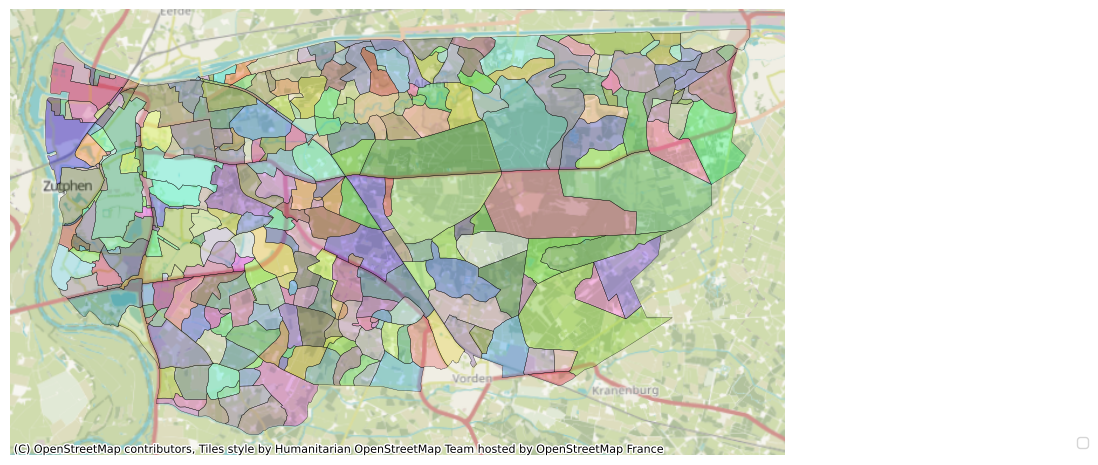

In [5]:
areas_dir               = Path(base_dir, network_name, "1_data", "areas")
areas_file_name         = f"{network_name}_afw_eenheden.shp"
areas_id_column         = "GFEIDENT"
network.read_areas(
    areas_file_path=Path(areas_dir, areas_file_name), 
    areas_id_column=areas_id_column
)
network.plot();

Read network data and extract objects and settings:
- extract network and weirs/pumps/culverts/etc
- read structure settings
- read laterals/boundaries/etc from basis simulations

  - MDU-file: ..\..\..\ribasim_lumping_data\tki_zutphen_berkel\2_dhydro\afvoergolf\tki_zuthpen_berkel_afvoergolf.dsproj_data\FlowFM\input\FlowFM.mdu
  - network: network-nodes (599x) branches (623x) nodes (2768x) edges (2792)
  - structures: culvert (435x), compound (532x), weir (48x), pump (6x), bridge (27x), universalWeir (16x), orifice (2x), pumps (6x->4x) 
  - external forcing (locations): boundaries (8x) laterals (362x)
  - external forcing (data): boundaries laterals
  - volume_tool: new level-volume dataframe created: PerGridpoint_volume.nc
  - MDU-file: ..\..\..\ribasim_lumping_data\tki_zutphen_berkel\2_dhydro\afvoergolf\tki_zuthpen_berkel_afvoergolf.dsproj_data\FlowFM\input\FlowFM.mdu
  - network: network-nodes (599x) branches (623x) nodes (2768x) edges (2792)
  - structures: culvert (435x), compound (532x), weir (48x), pump (6x), bridge (27x), universalWeir (16x), orifice (2x), pumps (6x->4x) 
  - external forcing (locations): boundaries (8x) laterals (362x)
  - external forc

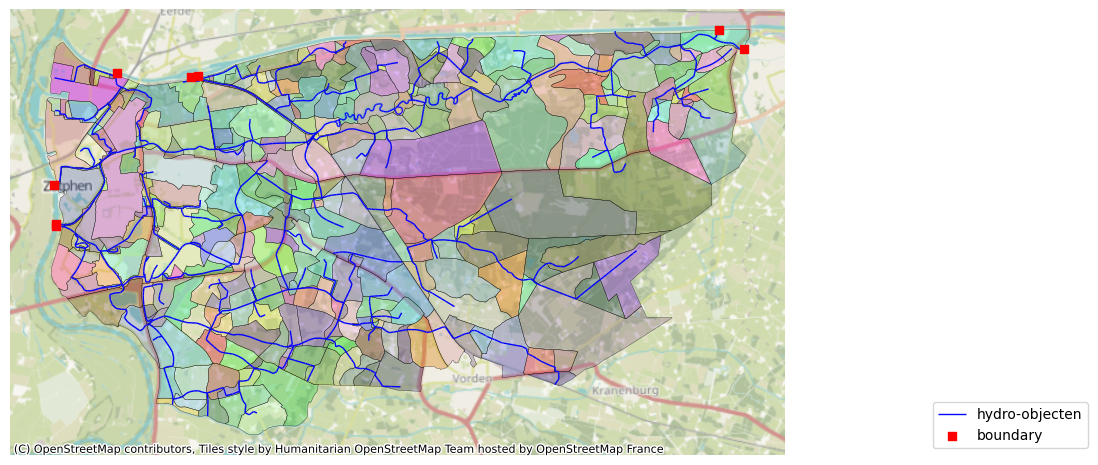

In [6]:
network.add_basis_network(
    source_type='dhydro',
    set_name="winter",
    set_start_month=10,
    set_start_day=1,
    model_dir=Path(dhydro_basis_dir, "afvoergolf"),
    simulation_name="tki_zuthpen_berkel_afvoergolf.dsproj_data",
    dhydro_volume_tool_bat_file=dhydro_volume_tool_bat_file, 
    dhydro_volume_tool_force=True,
    dhydro_volume_tool_increment=dhydro_volume_tool_increment
);
network.add_basis_network(
    source_type='dhydro',
    set_name="zomer",
    set_start_month=10,
    set_start_day=1,
    model_dir=Path(dhydro_basis_dir, "afvoergolf"),
    simulation_name="tki_zuthpen_berkel_afvoergolf.dsproj_data",
    dhydro_volume_tool_bat_file=dhydro_volume_tool_bat_file, 
    dhydro_volume_tool_force=True,
    dhydro_volume_tool_increment=dhydro_volume_tool_increment
);
network.plot();

In [7]:
network.pumps_gdf.head()

general                                                  \
     structure_id branch_id object_type  chainage edge_no node_no   
0  kgm_GM80750028      3913        pump  1.000000    2384      -1   
1  kgm_GM80920002      2592        pump  1.000000     106      -1   
2  kgm_GM80950124      4063        pump  1.344551    1692      -1   
3  kgm_GM84930001      4057        pump  3.028070    1686      -1   

                                           structure                           \
                                            comments orientation  controlside   
0  id=None name=None polylinefile='*.pli; Polylin...    positive  suctionSide   
1  id=None name=None polylinefile='*.pli; Polylin...    positive  suctionSide   
2  id=None name=None polylinefile='*.pli; Polylin...    positive  suctionSide   
3  id=None name=None polylinefile='*.pli; Polylin...    positive  suctionSide   

             ...                                winter                       \
  numstages  ... reductionfactor startlevelsuctionside stoplevelsuctionside   
0       1.0  ...           [1.0]                 [9.7]                [9.5]   
1       1.0  ...           [1.0]                [9.28]               [9.15]   
2       1.0  ...           [1.0]                [5.65]                [5.4]   
3       1.0  ...           [1.0]                 [5.2]                [4.8]   

                                                               zomer  \
  startleveldeliveryside stopleveldeliveryside startlevelsuctionside   
0                  [0.0]                 [0.0]                 [9.7]   
1                  [0.0]                 [0.0]                [9.28]   
2                  [0.0]                 [0.0]                [5.65]   
3                  [0.0]                 [0.0]                 [5.2]   

                                                                     \
  stoplevelsuctionside startleveldeliveryside stopleveldeliveryside   
0                [9.5]                  [0.0]                 [0.0]   
1               [9.15]                  [0.0]                 [0.0]   
2                [5.4]                  [0.0]                 [0.0]   
3                [4.8]                  [0.0]                 [0.0]   

                        geometry  
                                  
0  POINT (222853.758 464144.926)  
1  POINT (216580.942 457572.273)  
2  POINT (210161.557 460774.351)  
3  POINT (211236.786 463775.033)  

[4 rows x 23 columns]

In [8]:
network.weirs_gdf.iloc[0]

general    structure_id                                                             1
           branch_id                                                             4064
           object_type                                                           weir
           chainage                                                          1.190107
           edge_no                                                               1695
           node_no                                                                 -1
structure  comments                 id=None name='Given name in the user interface...
           allowedflowdir                                                        both
           crestwidth                                                             2.0
           corrcoeff                                                              1.0
           usevelocityheight                                                     True
winter     crestlevel                                 

In [9]:
network.culverts_gdf.iloc[0]

general    structure_id                                                kdu_DR80740069
           branch_id                                                             3971
           object_type                                                        culvert
           chainage                                                        217.929449
           edge_no                                                               2479
           node_no                                                                 -1
structure  comments                 id=None name=None polylinefile='*.pli; Polylin...
           allowedflowdir                                                        both
           leftlevel                                                             9.03
           rightlevel                                                            9.03
           csdefid                                                     kdu_DR80740069
           length                                     

In [10]:
network.orifices_gdf.iloc[0]

general    structure_id                                                kst_ST80810015
           branch_id                                                             3545
           object_type                                                        orifice
           chainage                                                         44.668106
           edge_no                                                               1465
           node_no                                                                 -1
structure  comments                 id=None name=None polylinefile='*.pli; Polylin...
           allowedflowdir                                                    positive
           crestlevel                                                             7.8
           crestwidth                                                             2.5
           corrcoeff                                                             0.63
           usevelocityheight                          

In [11]:
network.uniweirs_gdf.iloc[0]

general    structure_id                                                          1500
           branch_id                                                             4072
           object_type                                                  universalWeir
           chainage                                                          2.938987
           edge_no                                                               2491
           node_no                                                                 -1
structure  comments                 id=None name=None polylinefile='*.pli; Polylin...
           allowedflowdir                                                        both
           numlevels                                                              4.0
           yvalues                                         [-6.75, -4.75, 4.75, 6.75]
           zvalues                                             [10.9, 9.9, 9.9, 10.9]
           dischargecoeff                             

In [12]:
structure_specs_dir_path = Path(base_dir, network_name, "1_data", "control")
network.export_or_update_all_ribasim_structures_specs(
    structure_specs_dir_path=structure_specs_dir_path
);

 x ribasim_input_pump ('..\..\..\ribasim_lumping_data\tki_zutphen_berkel\1_data\control\ribasim_pumps_specs.xlsx') DOES exist. network.pumps_gdf will be UPDATED.
 x ribasim_input_weir ('..\..\..\ribasim_lumping_data\tki_zutphen_berkel\1_data\control\ribasim_weirs_specs.xlsx') DOES exist. network.weirs_gdf will be UPDATED.
 x ribasim_input_orifice ('..\..\..\ribasim_lumping_data\tki_zutphen_berkel\1_data\control\ribasim_orifices_specs.xlsx') DOES exist. network.orifices_gdf will be UPDATED.
 x ribasim_input_culvert ('..\..\..\ribasim_lumping_data\tki_zutphen_berkel\1_data\control\ribasim_culverts_specs.xlsx') DOES exist. network.culverts_gdf will be UPDATED.


Select simulation sets and extract all simulation results using xugrid/ugrid

In [13]:
network.add_simulation_set(
    source_type='dhydro',
    set_name="winter",
    model_dir=Path(dhydro_results_dir, "winter"),
    simulation_names=["tki_zuthpen_berkel_basis_winter.dsproj_data"],
    simulation_ts=pd.date_range("2000-01-06 23:00", periods=9, freq="6D"),
);
network.add_simulation_set(
    source_type='dhydro',
    set_name="zomer",
    model_dir=Path(dhydro_results_dir, "zomer"),
    simulation_names=["tki_zuthpen_berkel_basis_zomer.dsproj_data"],
    simulation_ts=pd.date_range("2000-01-06 23:00", periods=9, freq="6D"),
);

Read D-HYDRO simulations sets
 - Simulation set (winter): tki_zuthpen_berkel_basis_winter.dsproj_data | Timestamps: 9 | his.nc and map.nc
  - MDU-file: ..\..\..\ribasim_lumping_data\tki_zutphen_berkel\2_dhydro\winter\tki_zuthpen_berkel_basis_winter.dsproj_data\FlowFM\input\FlowFM.mdu
Read D-HYDRO simulations sets
 - Simulation set (zomer): tki_zuthpen_berkel_basis_zomer.dsproj_data | Timestamps: 9 | his.nc and map.nc
  - MDU-file: ..\..\..\ribasim_lumping_data\tki_zutphen_berkel\2_dhydro\zomer\tki_zuthpen_berkel_basis_zomer.dsproj_data\FlowFM\input\FlowFM.mdu


#### SET-UP SIMULATION
simulation code and temporal settings

In [14]:
simulation_code = "tki_zutphen_berkel"
# Definition settings changes over time
settings_time_variation = False
# in case of no variation over time. set set_name ("winter", "zomer", ...)
settings_set_name = 'winter'

Defition Lateral inflow over time
- method_laterals = 1: laterals basis network
- method_laterals = 2: laterals per discharge area > required: run function read_areas_laterals_timeseries(path_to_excel)
- method_laterals = 3: homogeneous discharge > required: define laterals_drainage_per_ha (pandas series) in liters/second/hectare

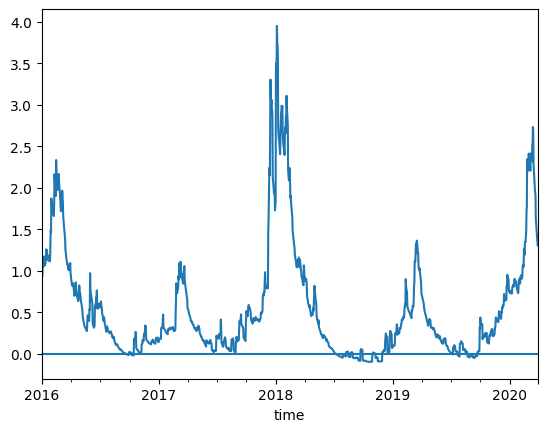

In [15]:
network.method_laterals = 2

# in case of 2: give direction to csv file with timeseries per area -> column names according to areas[areas_id_column]
areas_laterals_path = Path(base_dir, network_name, "1_data", "laterals", "laterals_areas.csv")
network.read_areas_laterals_timeseries(areas_laterals_path, sep=";", dayfirst=True)

fig, ax = plt.subplots(1,1)
network.laterals_areas_data.sum(axis=1).plot(ax=ax)
ax.hlines(0, xmin=network.laterals_areas_data.index[0], xmax=network.laterals_areas_data.index[-1])

Definition boundaries
- method_boundaries = 1: use boundaries basis network, 
- method_boundaries = 2: use timeseries from imported csv, 
- method_boundaries = 3: use fixed boundaries

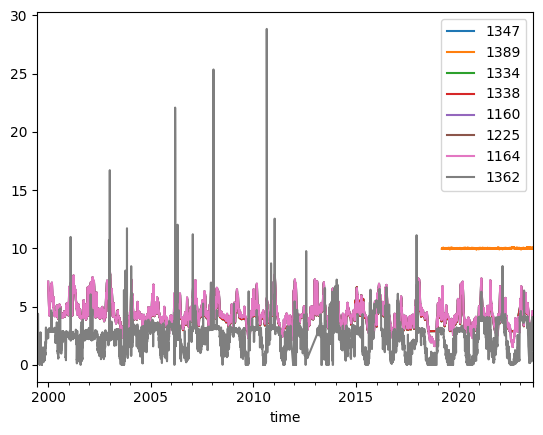

In [16]:
network.method_boundaries = 2

boundaries_timeseries_path = Path(base_dir, network_name, "1_data", "boundaries", "boundary_timeseries.csv")
network.read_boundaries_timeseries_data(boundaries_timeseries_path, skiprows=1, sep=";")
# small adjustment to datetime
network.boundaries_timeseries_data.index = network.boundaries_timeseries_data.index.floor(freq="D")
network.boundaries_timeseries_data.plot();

Changes to timeseries data:
- start and end time equal to laterals
- backward fill of data from Almen (1389)

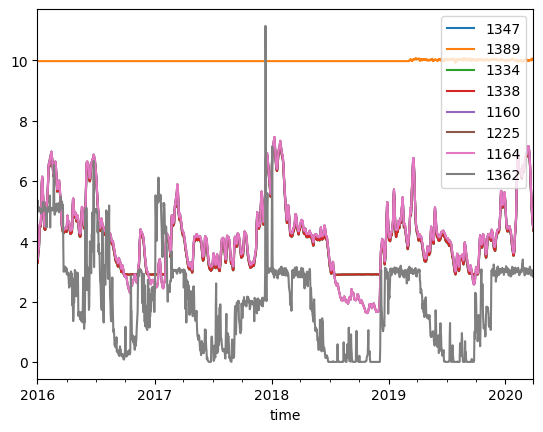

In [17]:
network.boundaries_timeseries_data = network.boundaries_timeseries_data.loc[
    network.laterals_areas_data.index[0]:network.laterals_areas_data.index[-1]
].bfill()
network.boundaries_timeseries_data.plot();

Definition initial water levels (refer to simulation name and index timestep)
- method_initial_waterlevels = 1: based on one of the basis simulations
- method_initial_waterlevels = 2: based on one of the simulations provided
- method_initial_waterlevels = 3: based on areas, define a column (zomerpeil/winterpeil) to be used (NOT YET IMPLEMENTED)

In [18]:
network.method_initial_waterlevels = 2

# give name of simulation plus the selected timestep (int)
network.initial_waterlevels_set_name = "winter"
network.initial_waterlevels_timestep = 3

#### ADD SPLIT NODES
use add_split_nodes function to add splitnodes. 
Select all weirs/pumps/uniweirs/orifices and/or select individual structures/objects to be included or excluded.

In [117]:
# Define locations where the network should be split into Ribasim basins:
network.add_split_nodes(
    weirs=True,
    pumps=True,
    uniweirs=True,
    orifices=True,
    culverts=False,
    edges=False,
    structures_ids_to_include=[
        'kdu_DR80760025', # duiker vispassage bovenstrooms
        'kdu_DR80770020', # duiker afvoergebiedje noordzijde Berkel
        'kdu_DR84930010', # duiker met terugslagklep Zutphen Noorderhaven (parallel aan gemaal)
        'kdu_DR80950033', # duikers voor wijk Leesten
        'kdu_DR80940046', 'kdu_DR80950043', 'kdu_DR80950151', # duikers voor wijk Zuidwijken
        'kdu_DR80950103',
        'kdu_DR80740070', # inlaat twentekanaal
        'kdu_DR80760004',
    ], 
    structures_ids_to_exclude=[
        'BCAL_3', 'BCAL_11', # stuwen voor hoogwaterafvoer De Berkel
        'BBypass_Besselink_2', 'BBypass_Besselink_3', 'BBypass_Besselink_4', 'BBypass_Besselink_5', 'BBypass_Besselink_6', # visdrempels vispassage De Berkel
        'kst_ST80950035', # verwarrende stuw ivm afwaterende eenheid (Zutphen: Leesten)
        'kst_ST84930001', # verwarrende stuw ivm afwaterende eenheid (Zutphen: Noorderhaven)
        # 'kst_ST80830045', # weir tussen uitstroompunten Zutphen
        # 'kst_ST80820031', 'kst_ST80820042', # test
        'kst_ST80940025' # losse tak
    ], 
    edge_ids_to_include=[1803],
);

70 split locations
 - pump: 4
 - weir: 45
 - orifice: 2
 - universalWeir: 9
 - culvert: 10


Conversion of choosen split_nodes to ribasim-type. Select standard conversion for objects and individual exceptions

In [20]:
split_node_type_conversion = dict(
    weir="TabulatedRatingCurve",
    universalWeir="TabulatedRatingCurve",
    pump="Pump",
    culvert="ManningResistance",
    edge="ManningResistance",
    orifice="Outlet",
    boundary_connection="ManningResistance"
)

# specify translation for specific split_nodes to ribasim-nodes
split_node_id_conversion = dict(
    kdu_DR80740070="Outlet"
    kdu_DR84930010="TabulatedRatingCurve",
    
    # duikers voor wijk Zuidwijken
    # kdu_DR80940046='ManningResistance', 
    # kdu_DR80950043='ManningResistance', 
    # kdu_DR80950151='ManningResistance', 
)

##### NETWORK GENERATION

In [21]:
network.generate_ribasim_lumping_network(
    simulation_code=simulation_code,
    split_node_type_conversion=split_node_type_conversion,
    split_node_id_conversion=split_node_id_conversion,
);

Create Ribasim network using Network and Split nodes:
 - create network graph from nodes (2768) and edges (2792x)
 - split network graph at split locations (69x)
 - define numbers Ribasim-Basins (51x) and join edges/nodes
 - check whether each split location results in a split (0 not used)
 - create final locations Ribasim-Basins (51)
 - define for each Ribasim-Basin the related basin area (46x)
 - create connections between Basins and split locations (138x)
 - create Ribasim-Edges between Boundaries and Basins
 - regenerate node-ids Ribasim-Nodes and Ribasim-Edges
 - define Ribasim-Nodes types based on input conversion table(s)
Exporting to geopackage:
 - available: areas, branches, nodes, edges, pumps, weirs, orifices, bridges, culverts, uniweirs, basin_areas, split_nodes, basins, basin_connections, laterals, boundaries, boundary_connections, 
 - not available: stations, node_h, node_a, node_v, basin_h, basin_a, basin_v, basins_nodes_h_relation, 
Export location: ..\..\..\ribasim_lum

In [101]:
ribasim_model = network.generate_ribasim_model_complete(
    set_name="winter",
    # dummy_model=True,
    saveat=3600,
)

basin-profile: generated
basin-state: generated
basin-state: generated as defined
basin-areas: generated
subgrid: based on water level relation basin and nodes
laterals: based on lateral inflow (timeseries) per area
flowboundaries: based on timeseries (1 flowboundaries)
levelboundaries: based on timeseries (7 levelboundaries)
pumps: generated (4 pumps)
outlets: generated (3 outlets)
tabulated_rating_curves: generated (54 tabulated_rating_curves)
 x 1 (weir): 3/21 records with decreasing discharge
 x kst_ST80750032 (weir): 6/21 records with decreasing discharge
 x kst_ST80760026 (weir): 7/21 records with decreasing discharge
 x kst_ST80770033 (weir): 6/21 records with decreasing discharge
 x kst_ST80770036 (weir): 6/17 records with decreasing discharge
 x basin_node_id 127: no discharge over split_node (weir): kst_ST80810010 in D-HYDRO simulation
 x basin_node_id 108: no discharge over split_node (weir): kst_ST80820070 in D-HYDRO simulation
 x kst_ST80830014 (weir): 1/21 records with de

In [102]:
ribasim_model

ribasim.Model(
    filepath=None,
    starttime=datetime.datetime(2016, 1, 1, 0, 0),
    endtime=datetime.datetime(2020, 3, 28, 0, 0),
    input_dir=WindowsPath('.'),
    results_dir=WindowsPath('results'),
    network=Network(filepath, node, edge),
    results=Results(outstate=None, compression=True, compression_level=6, subgrid=False),
    solver=Solver(algorithm='QNDF', saveat=3600.0, dt=None, dtmin=None, dtmax=None, force_dtmin=False, abstol=1e-06, reltol=1e-05, maxiters=1000000000, sparse=True, autodiff=True),
    logging=Logging(verbosity='info', timing=False),
    allocation=Allocation(timestep=None, use_allocation=False),
    basin=Basin(profile, state, time, subgrid, area),
    level_boundary=LevelBoundary(time),
    flow_boundary=FlowBoundary(time),
    manning_resistance=ManningResistance(static),
    tabulated_rating_curve=TabulatedRatingCurve(static),
    pump=Pump(static),
    outlet=Outlet(static),
)

In [116]:
ribasim_model.manning_resistance.static.df#.groupby("node_id").get_group(13)

,node_id,active,length,manning_n,profile_width,profile_slope,control_state
0,70,<NA>,750.0,0.04,5.0,3.0,NaN
1,71,<NA>,750.0,0.04,5.0,3.0,NaN
2,72,<NA>,750.0,0.04,5.0,3.0,NaN
3,73,<NA>,750.0,0.04,5.0,3.0,NaN
4,74,<NA>,750.0,0.04,5.0,3.0,NaN
5,75,<NA>,750.0,0.04,5.0,3.0,NaN
6,76,<NA>,750.0,0.04,5.0,3.0,NaN
7,77,<NA>,750.0,0.04,5.0,3.0,NaN
8,78,<NA>,750.0,0.04,5.0,3.0,NaN
9,79,<NA>,750.0,0.04,5.0,3.0,NaN


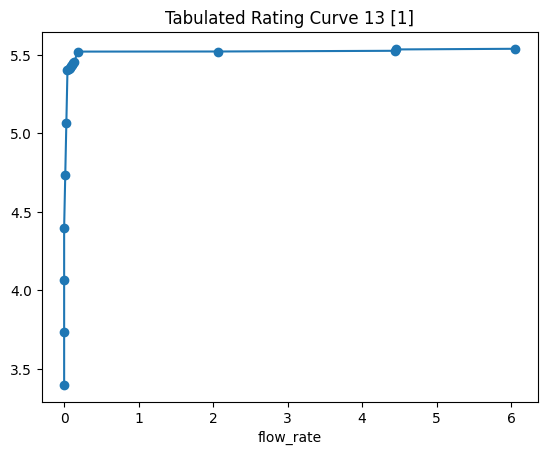

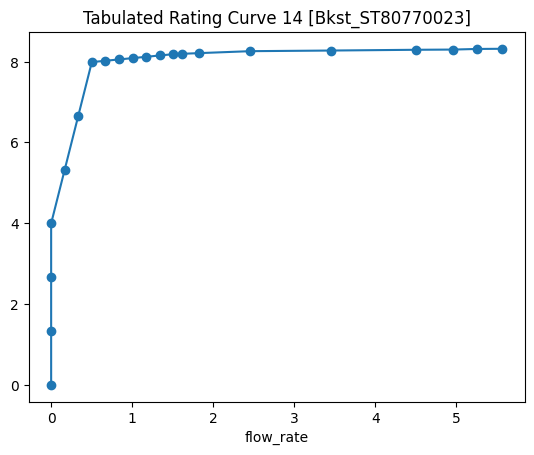

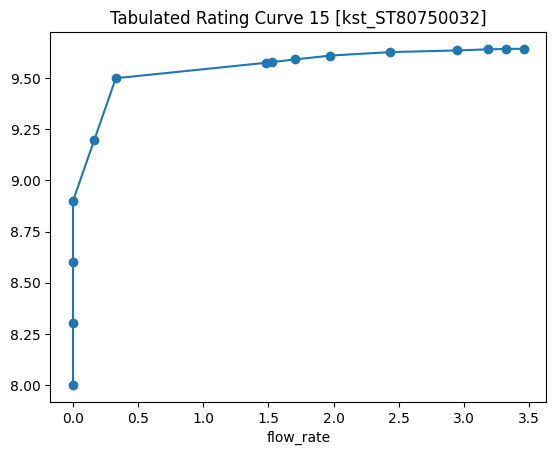

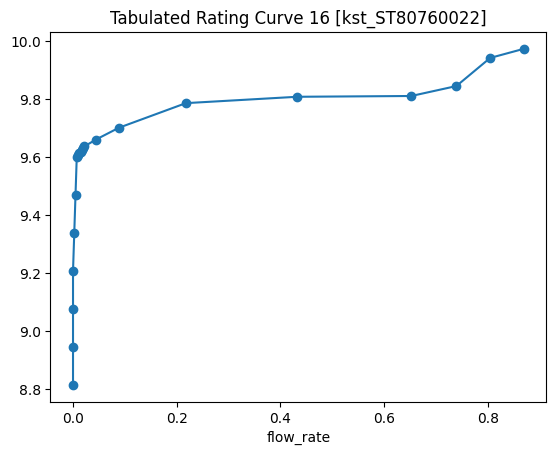

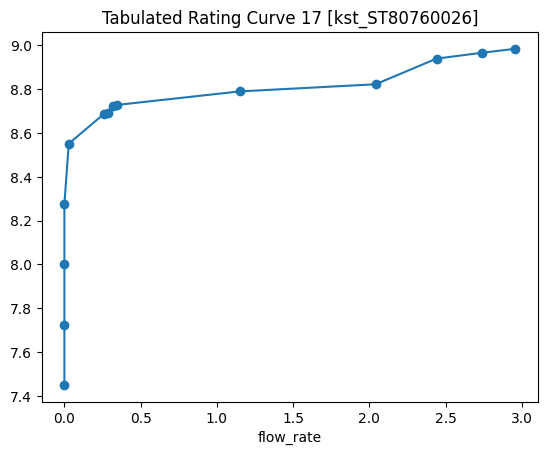

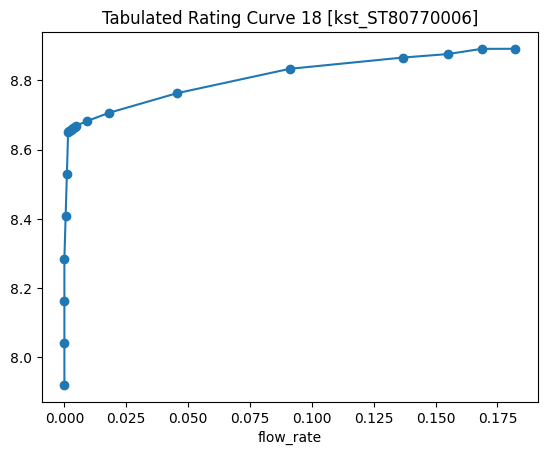

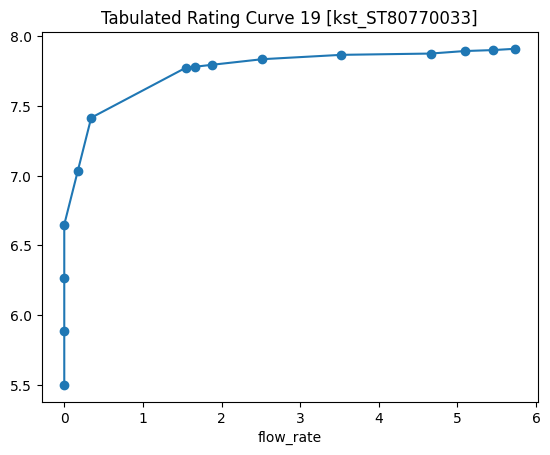

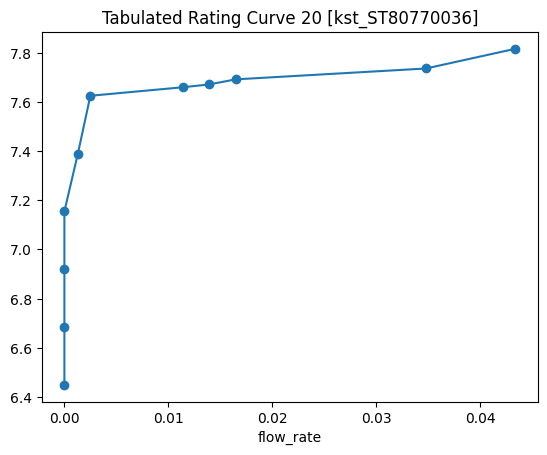

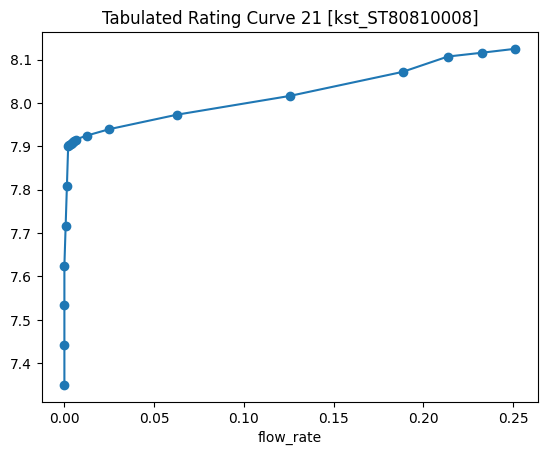

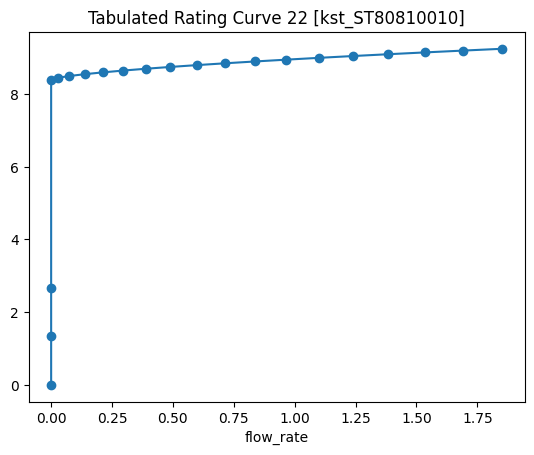

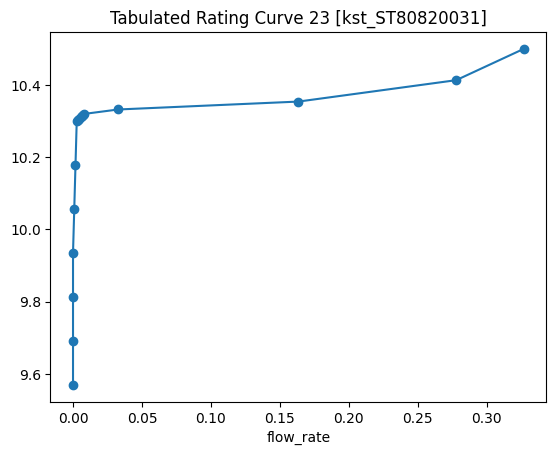

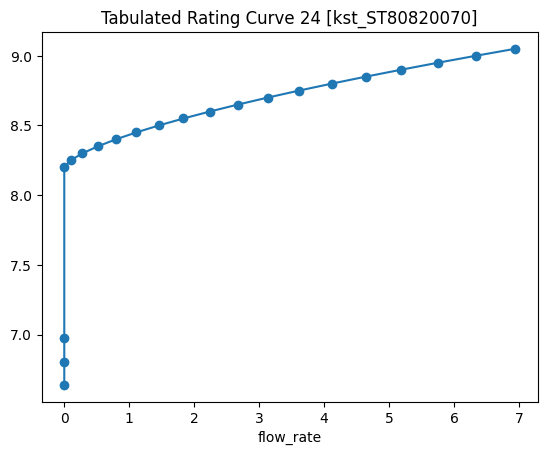

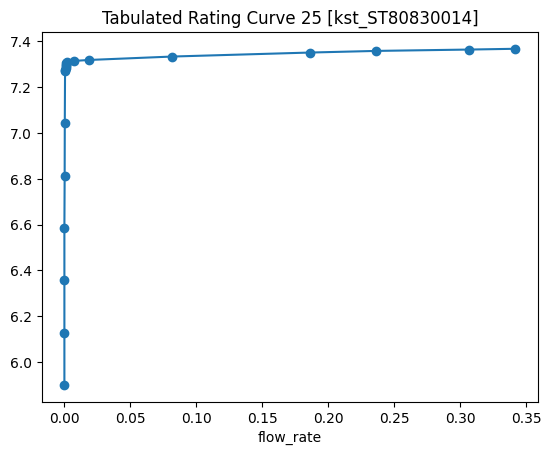

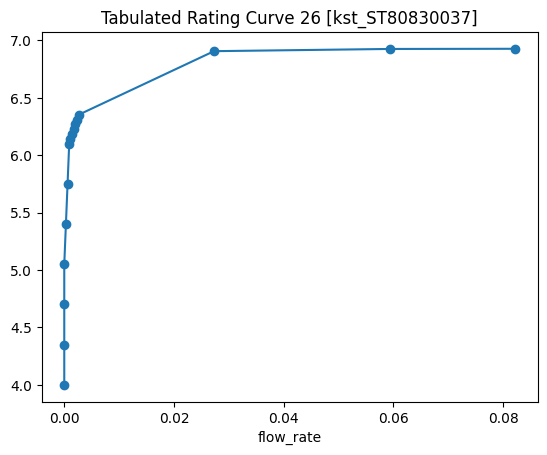

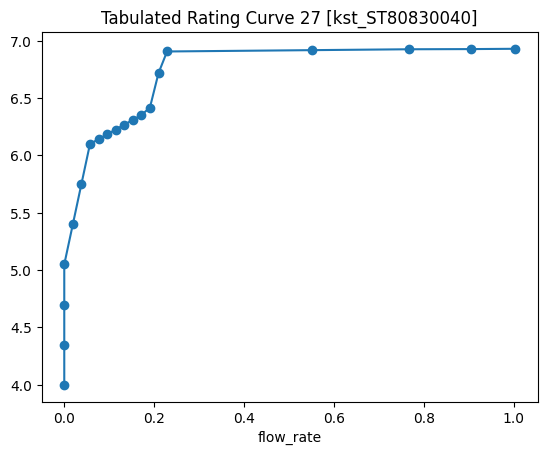

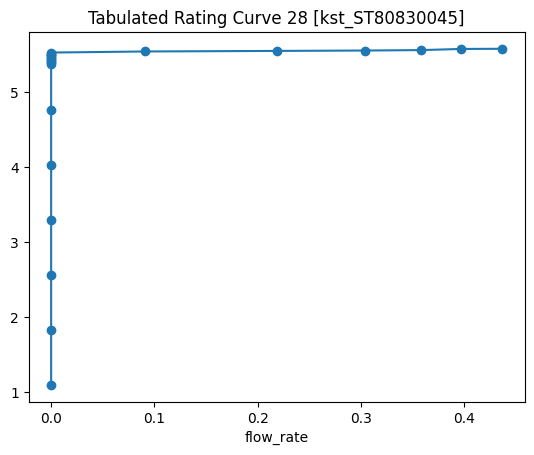

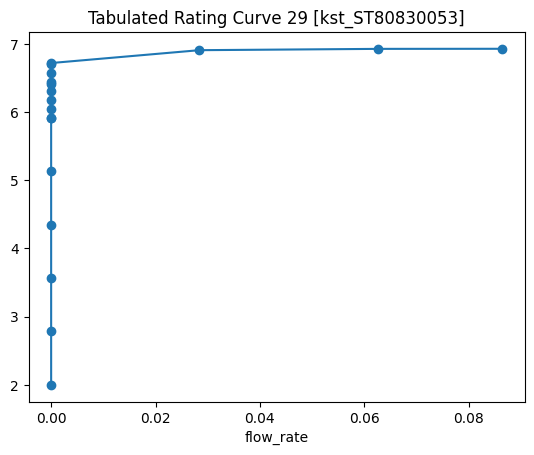

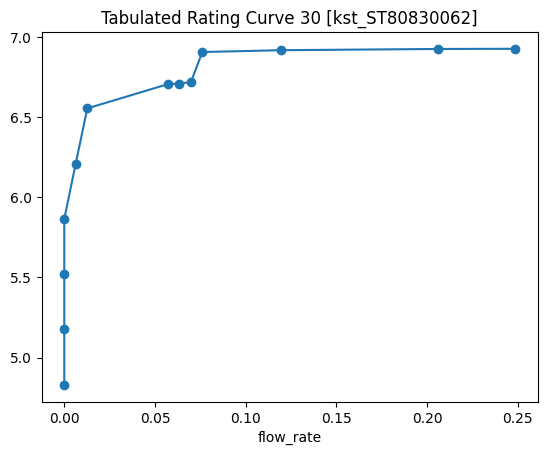

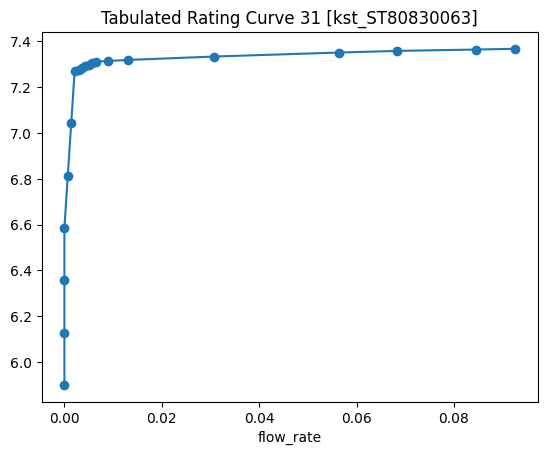

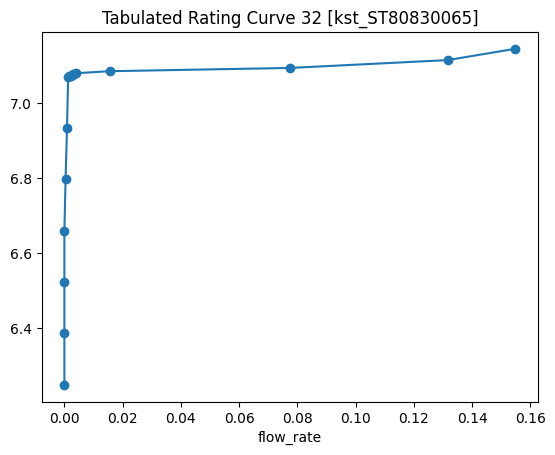

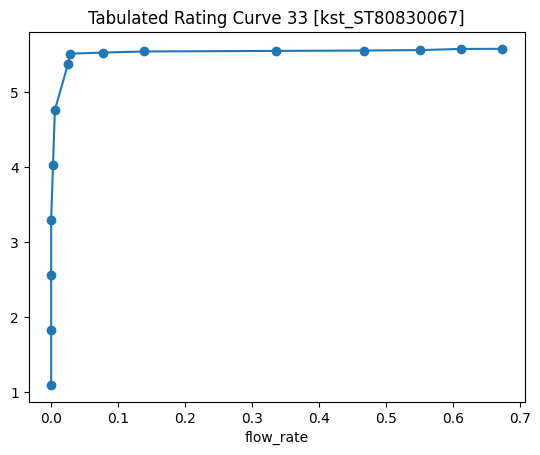

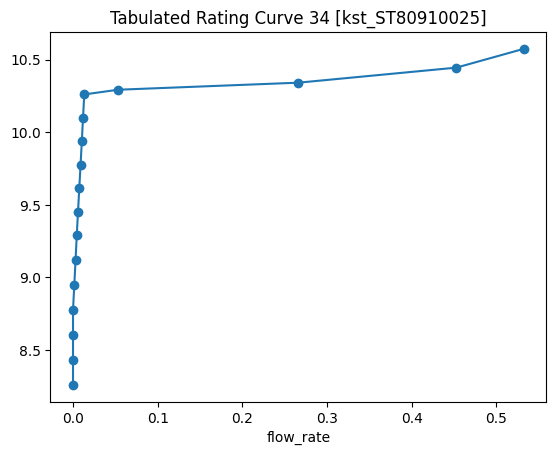

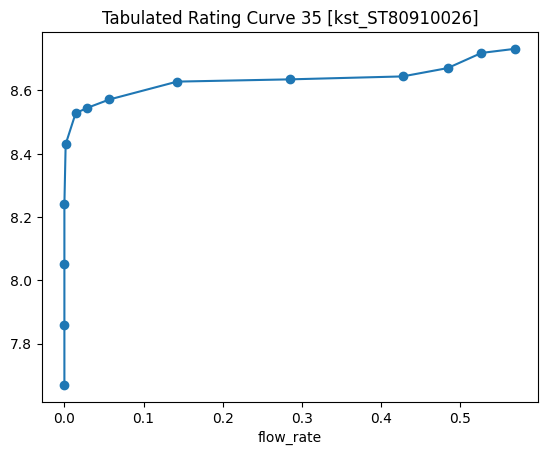

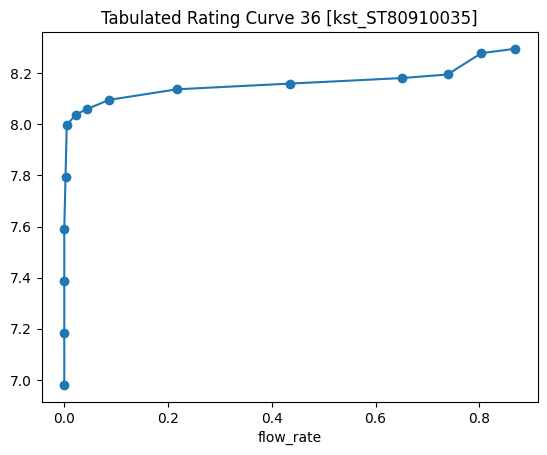

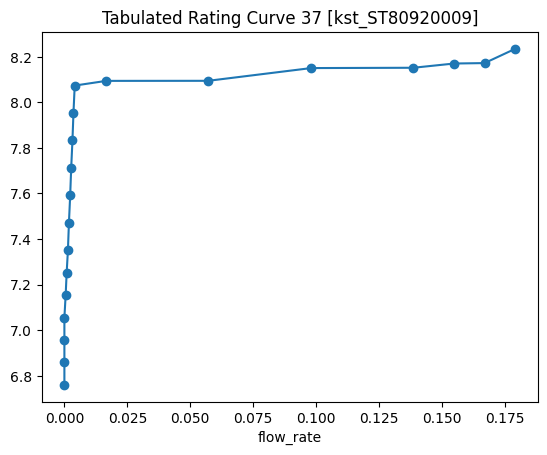

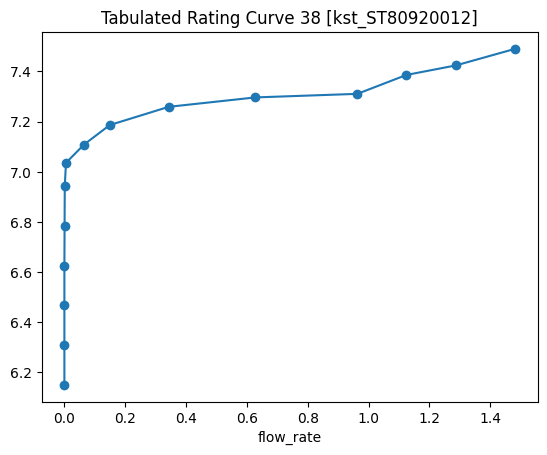

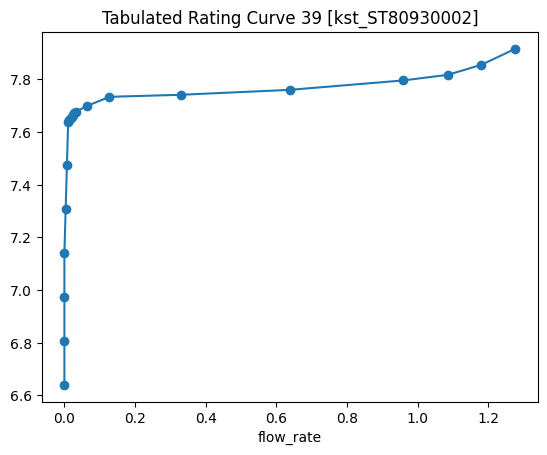

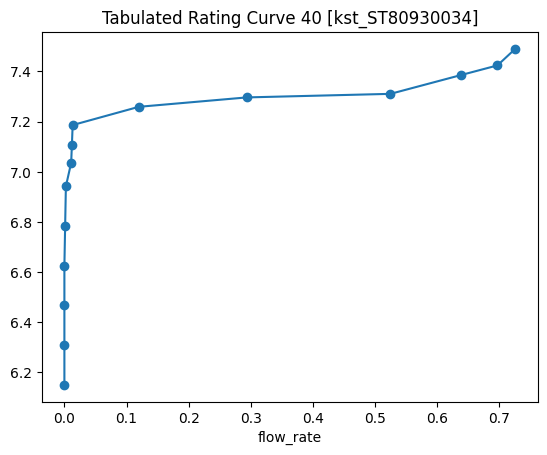

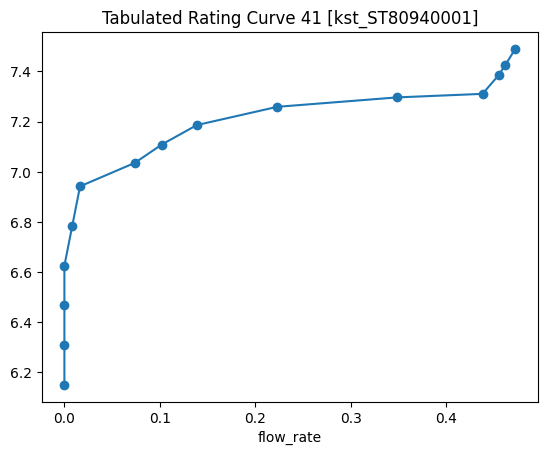

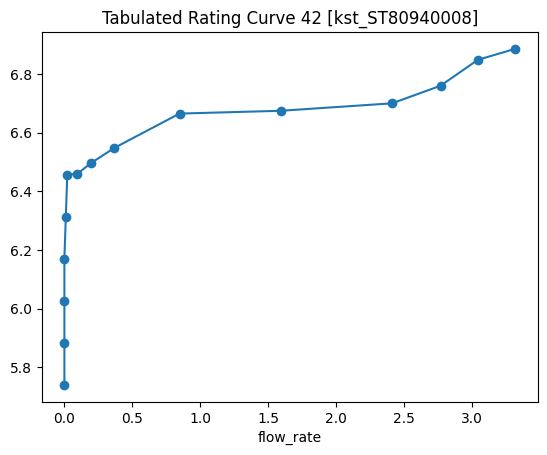

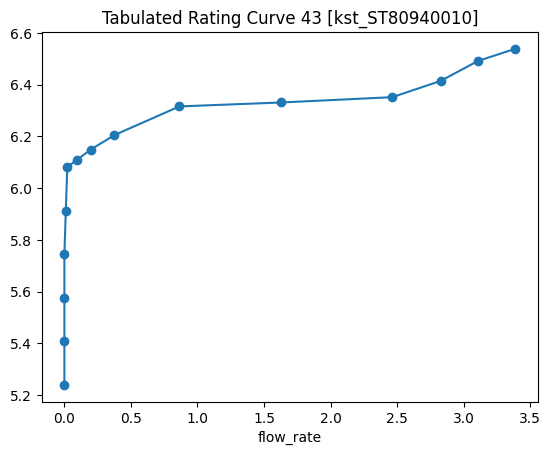

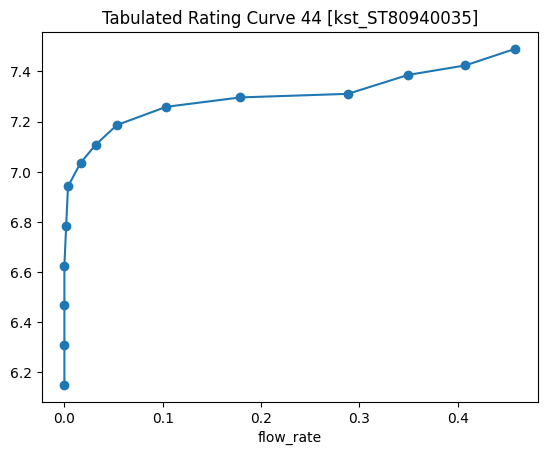

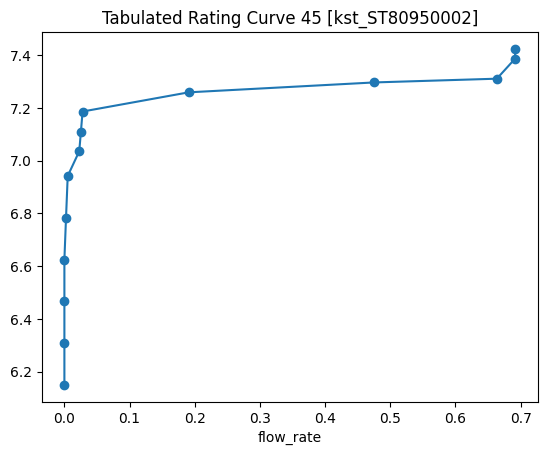

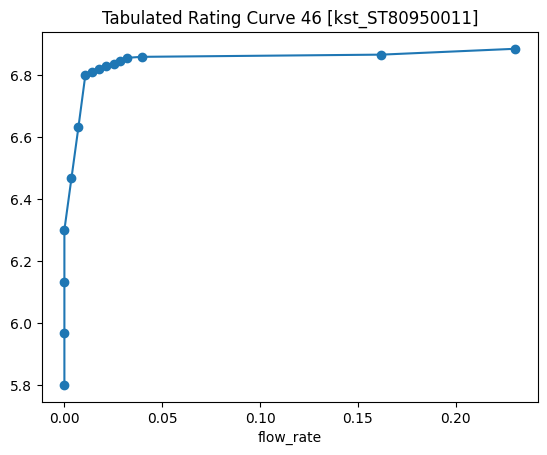

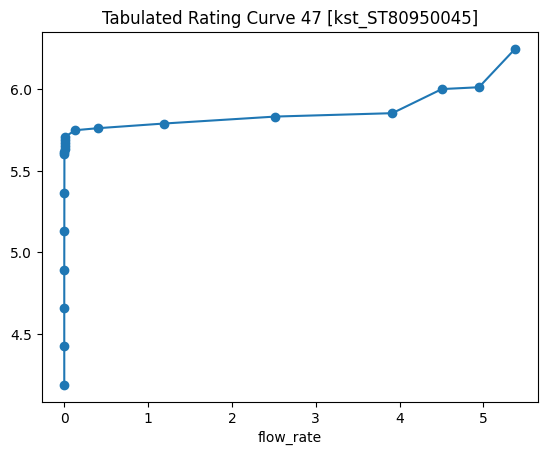

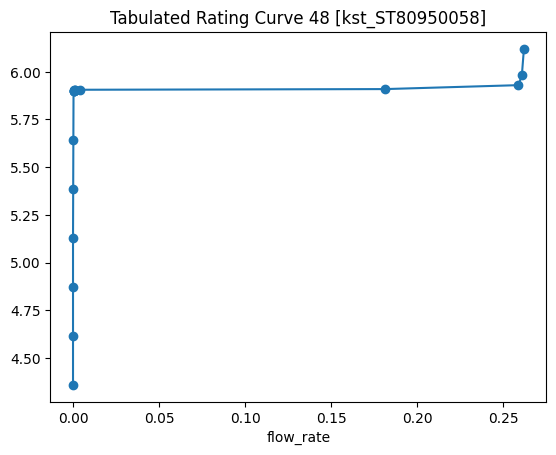

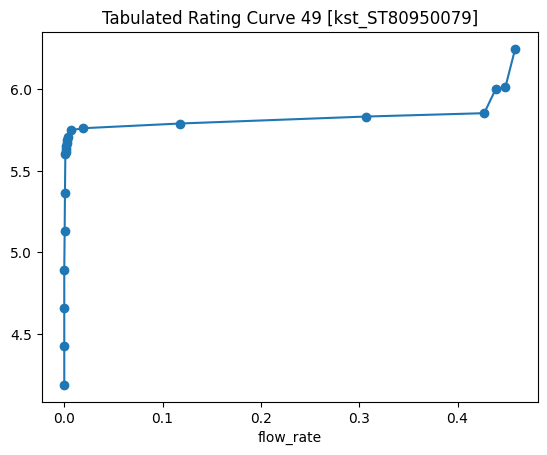

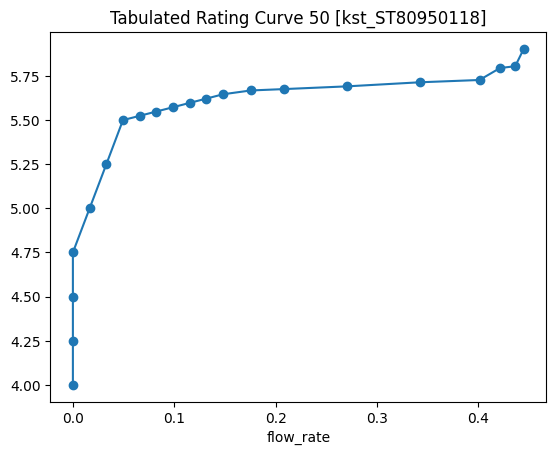

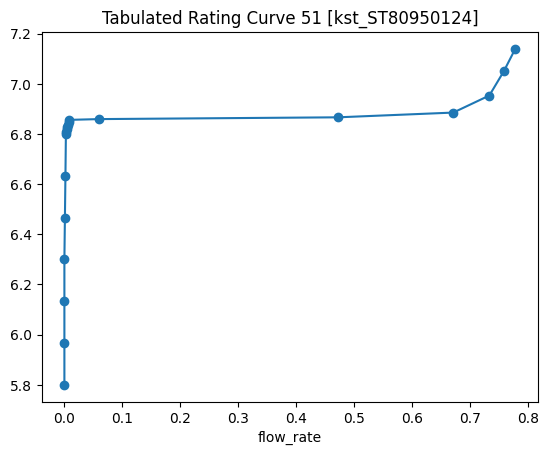

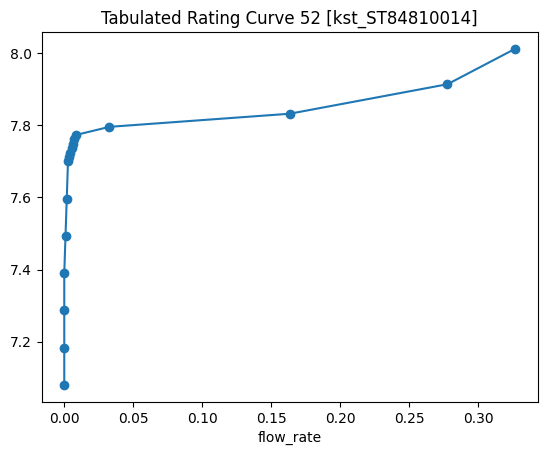

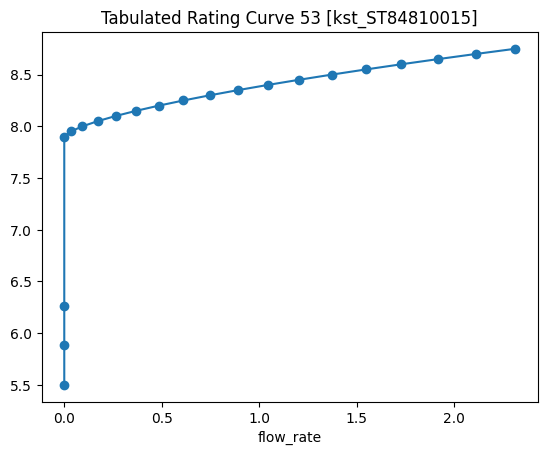

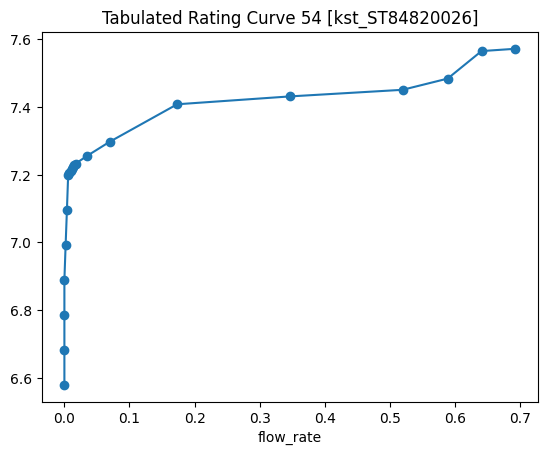

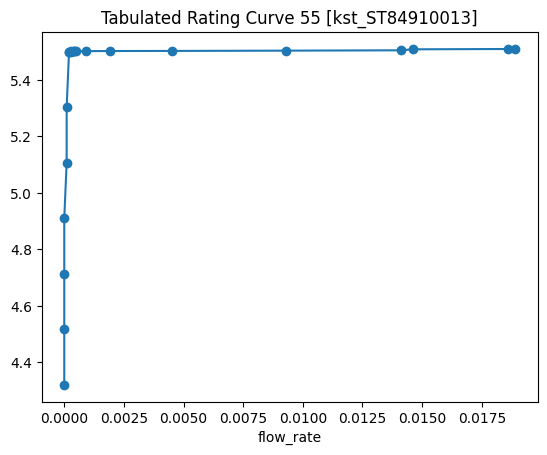

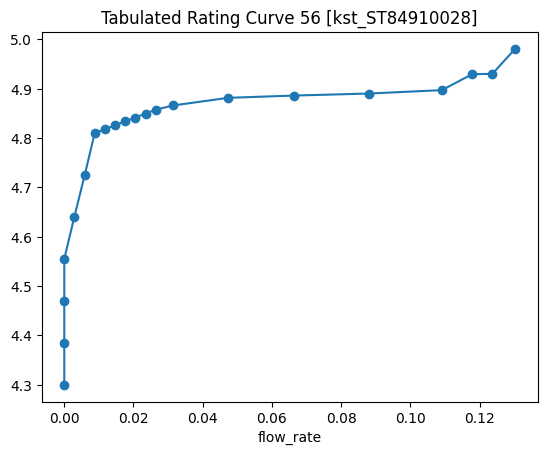

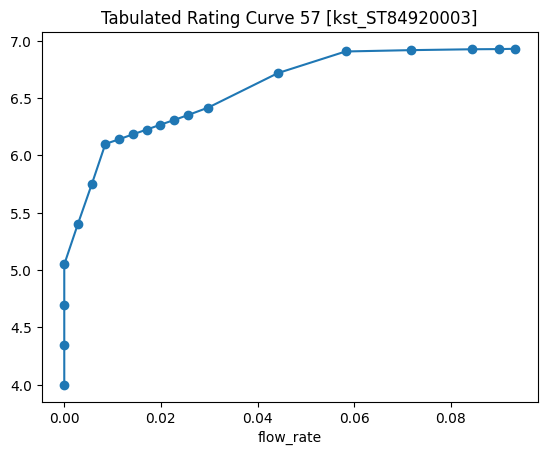

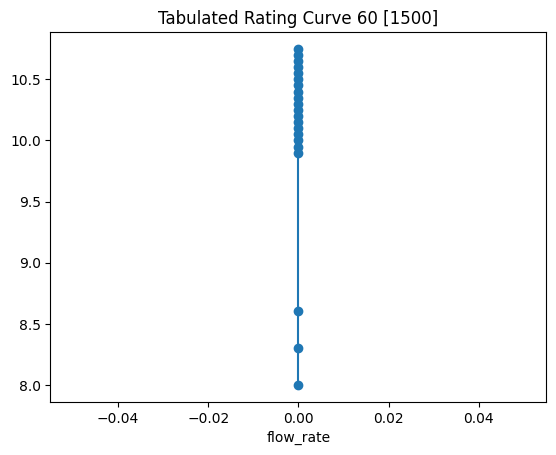

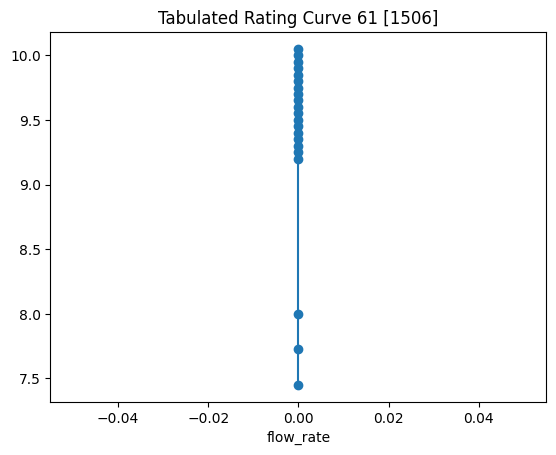

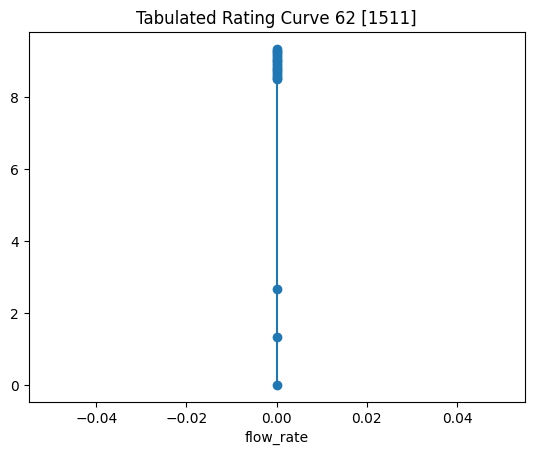

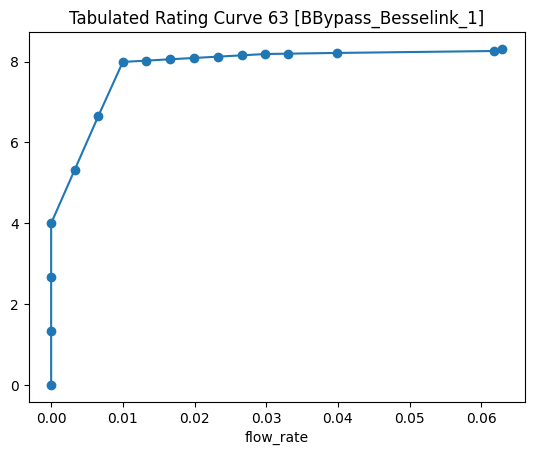

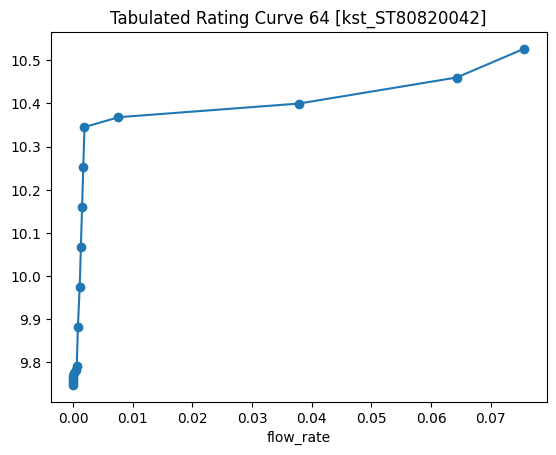

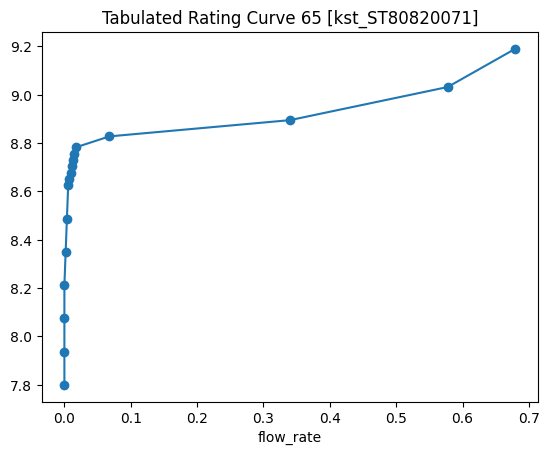

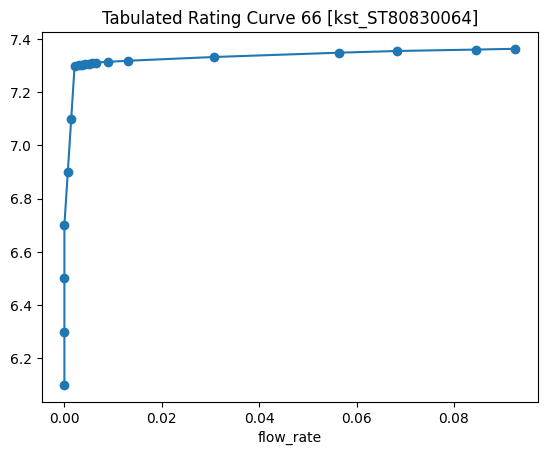

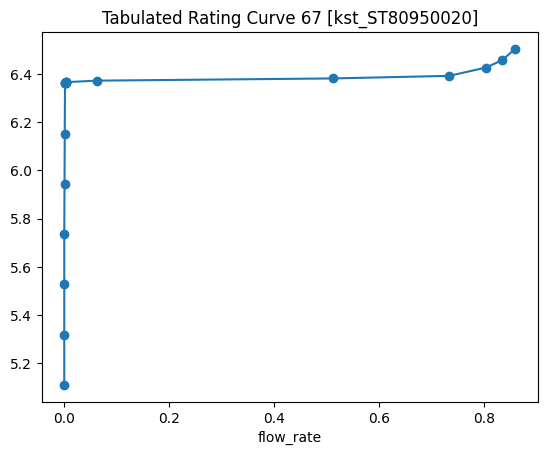

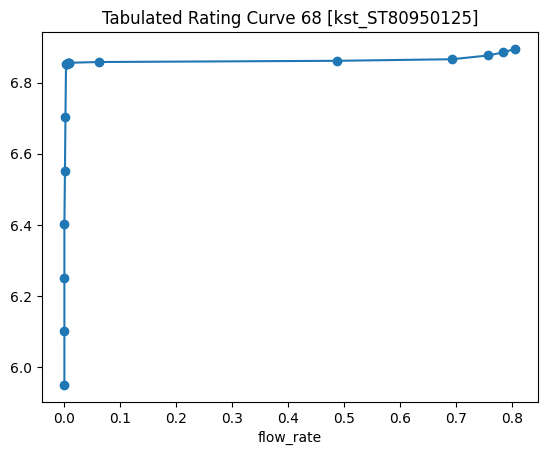

In [110]:
network.plot_tabulated_rating_curves()

##### ************ RUN MODEL BY RUNNING BAT-FILE ************

##### READ RESULTS FROM MODEL AND CREATE PLOTS

In [23]:
ribasim_results = read_ribasim_model_results(
    simulation_path=network.simulation_path
)

In [24]:
ribasim_results.flow

,time,edge_id,from_node_type,from_node_id,to_node_type,to_node_id,flow_rate
60,2020-01-01 00:00:00,0,Pump,9,Basin,136,0.000000
61,2020-01-01 00:00:00,1,Pump,10,Basin,90,0.000000
62,2020-01-01 00:00:00,2,Pump,11,Basin,123,0.000000
63,2020-01-01 00:00:00,3,TabulatedRatingCurve,13,Basin,123,0.000000
64,2020-01-01 00:00:00,4,Pump,12,Basin,122,0.000000
...,...,...,...,...,...,...,...
1888555,2020-12-31 23:00:00,150,ManningResistance,83,LevelBoundary,6,0.000003
1888556,2020-12-31 23:00:00,151,Basin,137,ManningResistance,84,0.989843
1888557,2020-12-31 23:00:00,152,ManningResistance,84,LevelBoundary,7,0.989843
1888558,2020-12-31 23:00:00,153,Basin,134,ManningResistance,85,0.000003


KeyError: 43

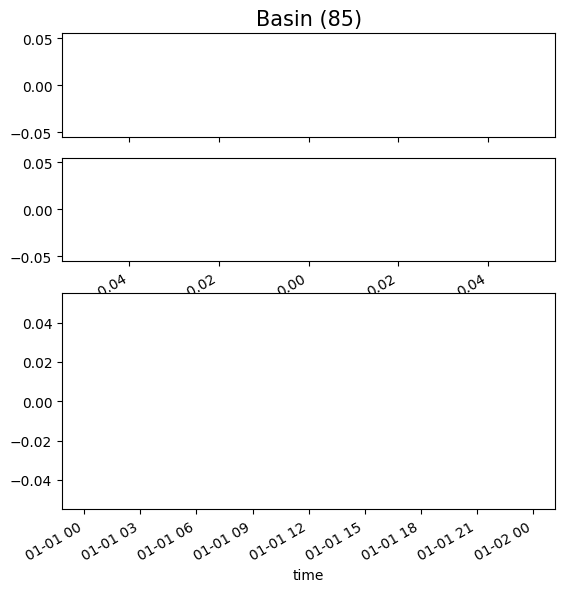

In [25]:
for basin_no in ribasim_model.basin.state.df.node_id.values:
    ribasim_model, ribasim_results, basin_results, fig, axes = plot_results_basin_ribasim_model(
        ribasim_model=ribasim_model,
        ribasim_results=ribasim_results,
        basin_no=basin_no
    );